In [1]:
import torch, torchvision
import torch.nn.functional as ff
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
#Configuration & Loading MNIST:
batch_size = 20

transform_src = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,)),])    #zero mean, unit variance

training_set = datasets.MNIST('./data/', train=True, download=True, transform=transform_src)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

testing_set = datasets.MNIST('./data/', train=False, download=True, transform=transform_src)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

In [3]:
#Building the model:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(28*28, 500)
        self.linear2 = nn.Linear(500, 250)
        self.linear3 = nn.Linear(250, 100)
        self.linear4 = nn.Linear(100, 50)
        self.output = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, img):
        x = img.view(-1, 28*28)        #Flatten
        x = self.leaky_relu(self.linear1(x))
        x = self.leaky_relu(self.linear2(x))
        x = self.leaky_relu(self.linear3(x))
        x = self.leaky_relu(self.linear4(x))
        x = self.softmax(self.output(x))
        return x

net = NeuralNetwork()

In [4]:
print(net)

NeuralNetwork(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=250, bias=True)
  (linear3): Linear(in_features=250, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
)


In [5]:
#Training the model:
cross_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
time0 = time()
epochs = 20
training_loss = []

for epoch in range(epochs):
    step_loss = []
    net.train()
    running_loss = 0
    for data in training_loader:
        x, y = data
        y_hot = ff.one_hot(y, num_classes=10) 
        optimizer.zero_grad()
        output = net(x.view(-1, 28*28))
        loss = cross_loss(output, y_hot.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  
        step_loss.append(loss.item())
    else:
        print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(training_loader)))
        training_loss.append(np.array(step_loss).mean())
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.5838887766599654
Epoch 1 - Training loss: 1.5417953712145487
Epoch 2 - Training loss: 1.5334058745304744
Epoch 3 - Training loss: 1.5403936019738516
Epoch 4 - Training loss: 1.5370588230689366
Epoch 5 - Training loss: 1.5405328805446625
Epoch 6 - Training loss: 1.5592356468836466
Epoch 7 - Training loss: 1.5464254873593648
Epoch 8 - Training loss: 1.54434297088782
Epoch 9 - Training loss: 1.5538462639649708
Epoch 10 - Training loss: 1.5502297070821127
Epoch 11 - Training loss: 1.5573471352656683
Epoch 12 - Training loss: 1.5602820426225663
Epoch 13 - Training loss: 1.5748212262392045
Epoch 14 - Training loss: 1.561950523495674
Epoch 15 - Training loss: 1.5737398679653805
Epoch 16 - Training loss: 1.5853977194229762
Epoch 17 - Training loss: 1.5626288117567697
Epoch 18 - Training loss: 1.5635521439313889
Epoch 19 - Training loss: 1.5612859262625376
Epoch 20 - Training loss: 1.5632321699460348


KeyboardInterrupt: 

In [6]:
#Testing the model:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    time00 = time()
    loss = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output, target).item()    #sum up batch loss
            pred = output.argmax(1, keepdim=True)        #get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print("\nTesting Time (in seconds) =",(time()-time00))

In [7]:
test(net, testing_loader)


Test set: Accuracy: 8724/10000 (87%)


Testing Time (in seconds) = 4.028842449188232


<function matplotlib.pyplot.show(close=None, block=None)>

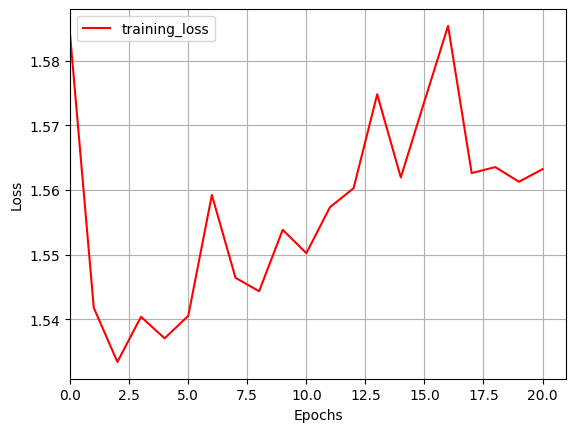

In [9]:
#plotting:
plt.plot(training_loss, label='training_loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 21)
plt.legend()
plt.grid(True)
plt.show